In [ ]:
!pip install tensorflow

In [ ]:
import tensorflow as tf
print(tf.__version__)

2.4.1


Linear Regression

(0.0, 6.0, 0.0, 20.0)

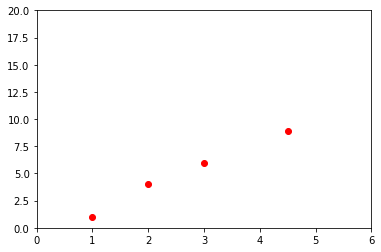

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

x = [1,2,3,4.5]
y = [1,4,6,8.9]
plt.plot(x,y,'ro')
plt.axis([0,6,0,20])

In [17]:
!pip install -q sklearn # instalación

In [18]:
# librerías necesarias para usar regresión lineal
from __future__ import absolute_import, division, print_function, unicode_literals

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import clear_output
from six.moves import urllib

import tensorflow.compat.v2.feature_column as fc

import tensorflow as tf

Datos

In [12]:
dataTrain = pd.read_csv('https://storage.googleapis.com/tf-datasets/titanic/train.csv') # training data, para entrenar al algoritmo
dataEval = pd.read_csv('https://storage.googleapis.com/tf-datasets/titanic/eval.csv') # testing/evaluation data, para saber cómo de preciso es el algoritmo (regresión lineal en este caso)

# Extraemos la columna survived de ambos DataSet (tablas)
yesTrain = dataTrain.pop('survived')
yesEval = dataEval.pop('survived')

In [ ]:
dataTrain.head() # para ver un dataset con los 5 primeros registros

,sex,age,n_siblings_spouses,parch,fare,class,deck,embark_town,alone
0,male,22.0,1,0,7.2500,Third,unknown,Southampton,n
1,female,38.0,1,0,71.2833,First,C,Cherbourg,n
2,female,26.0,0,0,7.9250,Third,unknown,Southampton,y
3,female,35.0,1,0,53.1000,First,C,Southampton,n
4,male,28.0,0,0,8.4583,Third,unknown,Queenstown,y


In [ ]:
dataTrain.describe() # descripción estadística del DataSet

,age,n_siblings_spouses,parch,fare
count,627.000000,627.000000,627.000000,627.000000
mean,29.631308,0.545455,0.379585,34.385399
std,12.511818,1.151090,0.792999,54.597730
min,0.750000,0.000000,0.000000,0.000000
25%,23.000000,0.000000,0.000000,7.895800
50%,28.000000,0.000000,0.000000,15.045800
75%,35.000000,1.000000,0.000000,31.387500
max,80.000000,8.000000,5.000000,512.329200


In [ ]:
dataTrain.shape

(627, 9)

627 registros (o listas) y 9 campos (después de haber sacado la columna 'survived'

In [ ]:
yesTrain.head() # de cada individuo si sobrevive o no

0    0
1    1
2    1
3    1
4    0
Name: survived, dtype: int64

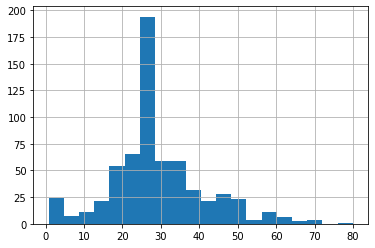

In [ ]:
dataTrain.age.hist(bins=20) # para dibuja histograma de la 'feature' 'age'

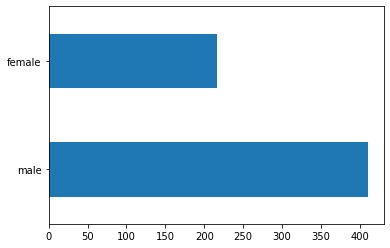

In [ ]:
#dftrain.sex.value_counts().plot(kind='barh')
dataTrain.sex.value_counts().plot(kind='barh')

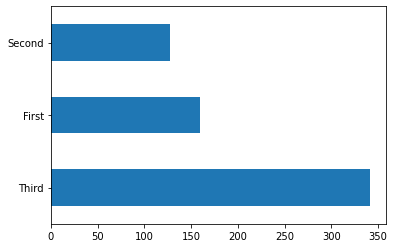

In [ ]:
#dftrain['class'].value_counts().plot(kind='barh')
dataTrain['class'].value_counts().plot(kind='barh') # en corchete para acceder a un campo concreto y tratar sus datos

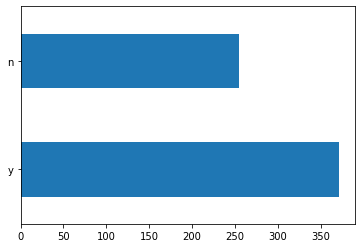

In [ ]:
dataTrain['alone'].value_counts().plot(kind='barh')

Text(0.5, 0, '% survive')

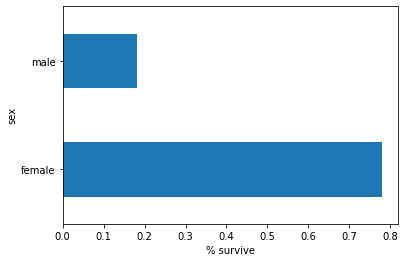

In [ ]:
# une dos un dataset con la columna que le había popado, los agrupa por sexo, hace la media de la supervivencia de cada sexo y la muestra
pd.concat([dataTrain,yesTrain], axis=1).groupby('sex').survived.mean().plot(kind='barh').set_xlabel('% survive')

Feature Columns

In [19]:
categoricalColumns = ['sex', 'n_siblings_spouses', 'parch', 'class', 'deck', 'embark_town', 'alone'] # array de campos categorical del DataSet

numericColumns = ['age', 'fare'] # array de campos numéricos

featureColumns = [] # declaración

# bucle para generar feature columns a partir de "campos categóricos"
for featureName in categoricalColumns: # en featureName se almacenan todos los nombres de campos o columnas
  vocabulary = dataTrain[featureName].unique() # extraemos todos los valores únicos de cada columna
  featureColumns.append(tf.feature_column.sequence_categorical_column_with_vocabulary_list(featureName, vocabulary)) # va añadiendo al array feature columns, pasándole el nombre y los valores posibles

# bucle para generar feature columns a partir de "campos numéricos"
for featureName in numericColumns:
  featureColumns.append(tf.feature_column.numeric_column(featureName, dtype=tf.float32))

print(featureColumns)


[SequenceCategoricalColumn(categorical_column=VocabularyListCategoricalColumn(key='sex', vocabulary_list=('male', 'female'), dtype=tf.string, default_value=-1, num_oov_buckets=0)), SequenceCategoricalColumn(categorical_column=VocabularyListCategoricalColumn(key='n_siblings_spouses', vocabulary_list=(1, 0, 3, 4, 2, 5, 8), dtype=tf.int64, default_value=-1, num_oov_buckets=0)), SequenceCategoricalColumn(categorical_column=VocabularyListCategoricalColumn(key='parch', vocabulary_list=(0, 1, 2, 5, 3, 4), dtype=tf.int64, default_value=-1, num_oov_buckets=0)), SequenceCategoricalColumn(categorical_column=VocabularyListCategoricalColumn(key='class', vocabulary_list=('Third', 'First', 'Second'), dtype=tf.string, default_value=-1, num_oov_buckets=0)), SequenceCategoricalColumn(categorical_column=VocabularyListCategoricalColumn(key='deck', vocabulary_list=('unknown', 'C', 'G', 'A', 'B', 'D', 'F', 'E'), dtype=tf.string, default_value=-1, num_oov_buckets=0)), SequenceCategoricalColumn(categorical_co

objeto tf.data.Dataset

- A continuación vemos una función que genera, a su vez, una inputFunction.
- Una inputfunction transforma un dataset del modelo pandas en un objeto tf.data.Dataset
- el objeto tf.data.Dataset : son instrucciones para "cómo alimentar al modelo"
- Parámetros
  - data: es el dataframe de pandas (train o eval)
  - label: la columna survived de cada dataset que habíamos hecho pop
  - numEpochs = el nº de veces que se le dan los datos al modelo
  - shuffle = si se randomiza el orden en el que se le dan los datos al modelo
  - batchSize = el nº de filas que se le dan al modelo cada vez.
- Métodos:
  - dict(): crea un dicionario (clave:valor) a partir un dataset y un label
  - from_tensor_slices(): divide en tensor en capas (mirar documentación).

In [ ]:
## edu hay algo mal aquí
def makeInputFunction(data, label, numEpochs=10, shuffle=True, batchSize=32): 
  def inputFunction(): # esta es la función que será devuelta
    dataset = tf.data.Dataset.from_tensor_slices( (dict(data), label )) # create tf.data.Dataset object with data and its label
    if shuffle:
      dataset = ds.shuffle(1000) # randomiza el dataset
    dataset = ds.batch(batchSize).repeat(numEpochs) # divide el dataset en bloques que se le pasan al modelo en batches de tamaño batchSize (32) y se repite el nº de epochs veces.
    return dataset
  return inputFunction

trainInputFunction = makeInputFunction(dataTrain, yesTrain)# input function para el dataset de entrenamiento (dataset, label)
evalInputFunction = makeInputFunction(dataEval,yesEval, numEpochs=1, shuffle=False) # input function para el dataset de test. Cuando testeamos el modelo no hace falta randomizar el dataset o pasarle los datos más de una vez (epoch)

In [31]:


###

def make_input_fn(data_df, label_df, num_epochs=10, shuffle=True, batch_size=32):
  def input_function():  # inner function, this will be returned
    ds = tf.data.Dataset.from_tensor_slices((dict(data_df), label_df))  # create tf.data.Dataset object with data and its label
    if shuffle:
      ds = ds.shuffle(1000)  # randomize order of data
    ds = ds.batch(batch_size).repeat(num_epochs)  # split dataset into batches of 32 and repeat process for number of epochs
    return ds  # return a batch of the dataset
  return input_function  # return a function object for use

train_input_fn = make_input_fn(dataTrain, yesTrain)  # here we will call the input_function that was returned to us to get a dataset object we can feed to the model
eval_input_fn = make_input_fn(dataEval, yesEval, num_epochs=1, shuffle=False)

Creación del modelo

- estimator: es un módulo de tensorflow
- LinearClassifier: es un objeto que creará un modelo a partir de los feature columns

In [32]:
linearEstimator = tf.estimator.LinearClassifier(feature_columns=featureColumns) # Creamos el estimator (estimador basado en el modelo de regresión lineal) usando las feature columns que creamos antes a partir de los dataset

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmpw8ep87tw', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_checkpoint_save_graph_def': True, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


## Entrenamiento del modelo
- Usamos el modelo que hemos creado, el método train y le pasamos por parámetro la input function

- Lo que guardamos es el resultado de testear el modelo, que se llama usando el método evaluate, al cual le pasamos la input function con el dataset de evaluación

In [34]:
linearEstimator.train(train_input_fn)  # la función que le pasamos como parámetro es la que entrena al modelo de la manera que hemos implementado antes
result = linearEstimator.evaluate(eval_input_fn)  # evaluamos el modelo una vez entrenado, con la otra input function (la de evaluacion)

clear_output() # limpia el log de la consola (información que no necesitamos)
print(result['accuracy']) # muestra el campo 'acuracy' del resultado de evaluar el modelo

0.7537879
